In [1]:
import os
from datetime import datetime as dt
import pandas as pd
import seaborn as sns
from datagenic_rest_client.datagenic import DataGenic
from tshistory.api import timeseries
import matplotlib.pyplot as plt
from DG import get_prices_df

datagenic_rest_server = "http://lon-qdev-ap11"
tsa = timeseries('http://tst-qdev-ap9.petroineos.local/api')

d = DataGenic(
    url_rest_wrapper=datagenic_rest_server, datagenic_url=os.environ["datagenicserver"],
  datagenic_username=os.environ["datagenicusername"], datagenic_password=os.environ["datagenicpassword"])

In [12]:
%matplotlib inline

In [2]:
plt.style.use('ggplot')

In [165]:
model_dict = {
    'TD25_M00':"model://BALT_FFA/EU.FR.FFA.TD25.BALTIC.M00",
    "TD3_M00":"model://BALT_FFA/EU.FR.FFA.TD3.BALTIC.M00"
    }

In [166]:
df = get_prices_df(model_dict=model_dict, start=dt(2018,1,1))

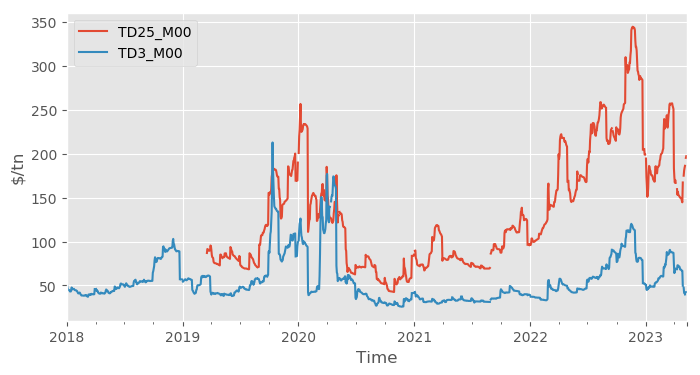

In [167]:
df.plot(ylabel='$/tn', figsize=(8,4))

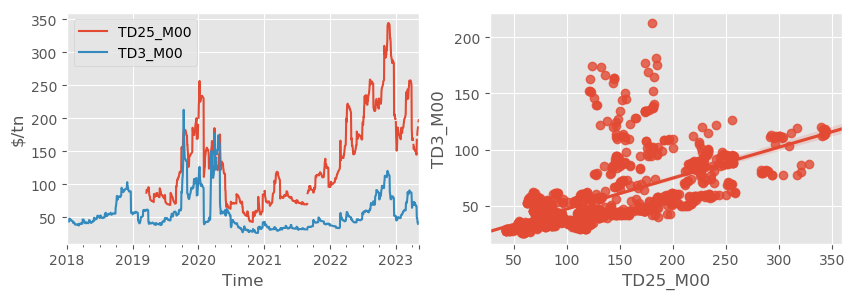

In [168]:
# df['adjusted_freight_exposure'] = df['TD25_M00'] - df['TD3_M00']
fig, ax = plt.subplots(ncols=2, figsize=(10,3))
df.plot(y=['TD25_M00','TD3_M00'] , ylabel='$/tn', ax=ax[0])
sns.regplot(data=df, x='TD25_M00',y='TD3_M00', ax=ax[1])

In [169]:
spread = df.TD25_M00 - df.TD3_M00

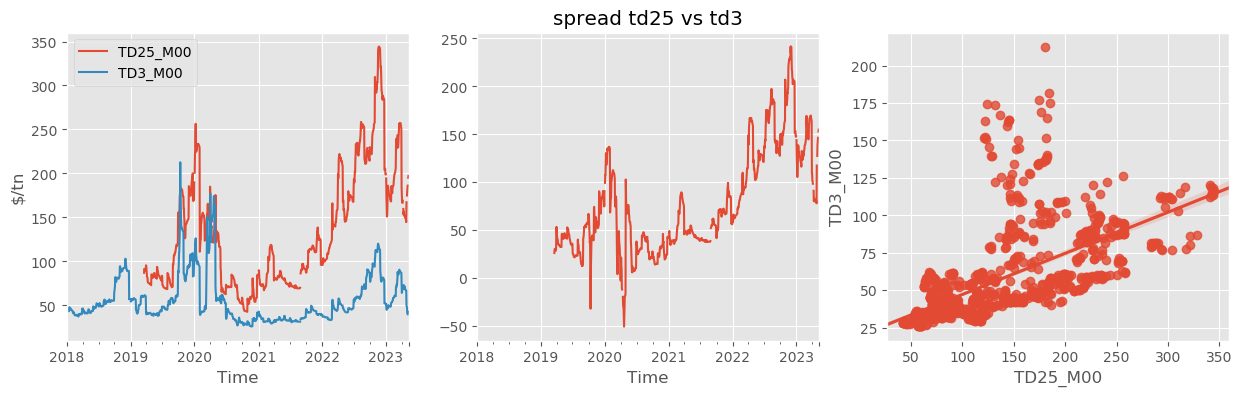

In [170]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4))
df.plot(y=['TD25_M00','TD3_M00'] , ylabel='$/tn', ax=ax[0])
spread.plot(title='spread td25 vs td3', ax=ax[1])
sns.regplot(data=df, x='TD25_M00',y='TD3_M00', ax=ax[2])

In [171]:
def convert_seasonal_daily(series):
    df = series.to_frame()
    df['year'] = df.index.year
    df['day'] = df.index.day
    # return df.pivot(columns='year', index='day')
    return df

In [172]:
# td3_ = df.TD3_M00
td3_ = df.TD25_M00
td3 = td3_.resample('d').interpolate()
td3_seasonal = td3.groupby([td3.index.year,td3.index.strftime('%m-%d')]).mean()

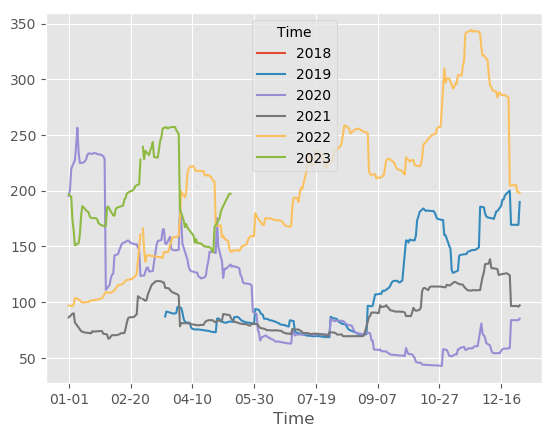

In [173]:
td3_seasonal.unstack().T.plot()

In [174]:
us_net_length = tsa.get("crude.petroineos.united_states.net_length.kbd.monthly")
TD25_M00_m = df.TD25_M00.dropna().resample('MS').mean()
df_us = pd.merge(TD25_M00_m,us_net_length, left_index=True, right_index=True)

In [175]:
df_us.head()

TD25_M00  crude.petroineos.united_states.net_length.kbd.monthly
2019-03-01  90.531000                                           -4020.91    
2019-04-01  78.566650                                           -4198.10    
2019-05-01  83.577048                                           -4570.69    
2019-06-01  83.310700                                           -5027.83    
2019-07-01  71.307565                                           -5274.53

In [176]:
df_range = df_us[(df_us['crude.petroineos.united_states.net_length.kbd.monthly']<-3800) & (df_us['crude.petroineos.united_states.net_length.kbd.monthly']>-4200)]

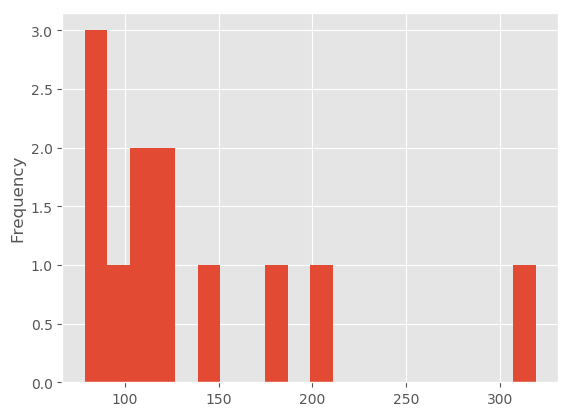

In [177]:
df_range.TD25_M00.plot.hist(bins=20)

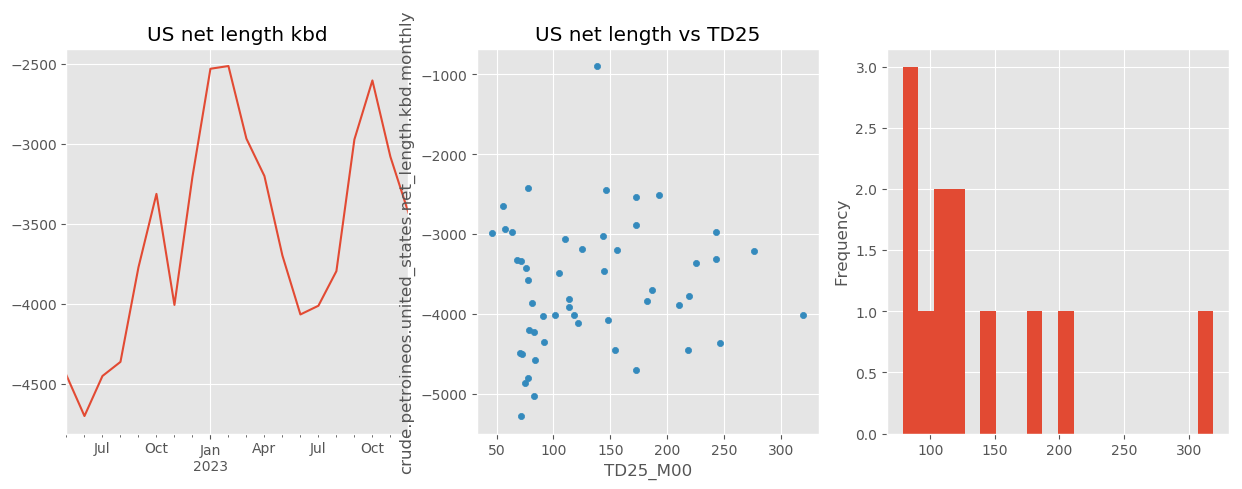

In [181]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
us_net_length.tail(20).plot(ax=ax[0], title='US net length kbd')
df_us.plot.scatter('TD25_M00', 'crude.petroineos.united_states.net_length.kbd.monthly', title='US net length vs TD25', ax=ax[1])
df_range.TD25_M00.plot.hist(bins=20, ax=ax[2], title='av. ws for net length around -4mbd')